# Indiana Pines

1. Import dependencies

In [ ]:
import random
import torch
import multiprocessing
import numpy as np

import torch.utils.data as data

from torch import nn

from sklearn.model_selection import train_test_split

from src.trainer.classification_trainer import ClassificationTrainer
from src.trainer.clustering_trainer import LabelPropagationTrainer
from src.util.torch import resolve_torch_device
from src.util.hsi import (
    extract_patches,
    reduce_hsi_dim,
    train_test_band_patch_split,
    preprocess_hsi,
    PreProcessType,
    DimReductionType,
)
from src.data.indian_pines import load_indian_pines
from src.model.lenet import FullyConvolutionalLeNet
from src.visualization.plot import (
    plot_segmentation_comparison,
    plot_epoch_generic_comparison,
    plot_epoch_generic,
    plot_k_values,
)
from src.data.dataset_decorator import UnlabeledDatasetDecorator
from src.util.reporting import (
    create_model_name,
    report_run,
    read_report_to_show,
    classification_trainer,
)
from src.trainer.base_trainer import AdamOptimizedModule
from src.util.over_clustering import exponential_decay_over_clustering
from src.pipeline.common import KMeansClustering

2. Prepare env

In [ ]:
learning_rate = 1e-3
num_epochs = 30
scheduler_step_size = num_epochs 
scheduler_gamma = 0.9
weight_decay = 0

lambda_v = 0.495
clusters_count = 12
k_star_multiplier = 3
semantic_threshold = 0.5
spatial_constraint_weights = [1, 0.5]
spatial_threshold = 8

In [3]:
batch_size = 33
patch_size = 9
target_dim = 75

pre_process_type = PreProcessType.NORMALIZATION
dim_reduction_type = DimReductionType.PCA

In [4]:
random_seed = 42

random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = resolve_torch_device()

generator = torch.Generator()
generator.manual_seed(random_seed)

In [5]:
torch.cuda.empty_cache()

In [6]:
torch.set_float32_matmul_precision("medium")

In [7]:
f"Device is {device}"

'Device is cuda'

3. Load dataset

In [8]:
image, labels = load_indian_pines()

image_h, image_w, image_c = image.shape

In [9]:
_, image = preprocess_hsi(image, pre_process_type)

In [10]:
_, target_dim, image = reduce_hsi_dim(
    image, target_dim, dim_reduction_type, device, random_seed
)

In [11]:
x, y = extract_patches(image, labels, patch_size=patch_size)

In [12]:
num_classes = len(np.unique(y))

f"Number of classes {num_classes}"

'Number of classes 17'

In [13]:
examples_per_class = [20] * num_classes

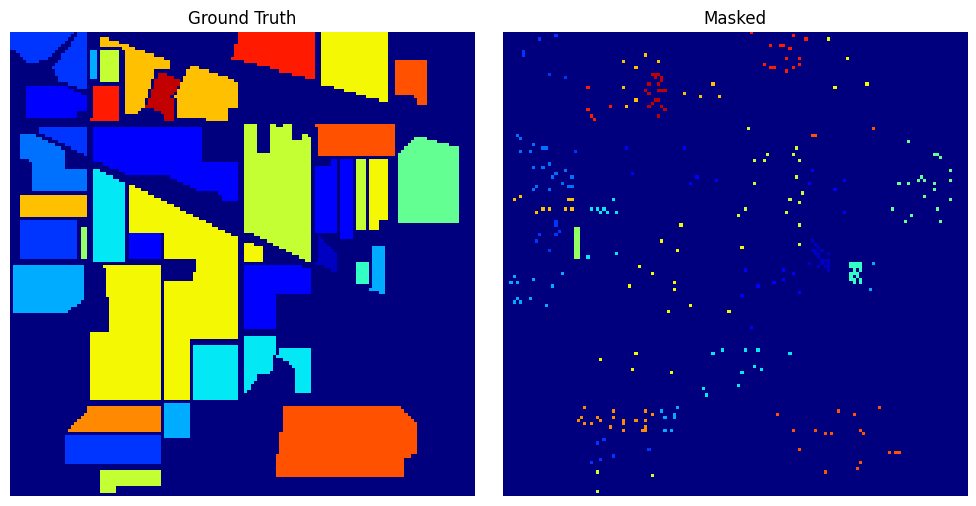

In [14]:
if examples_per_class:
    x_train, y_train, x_test, y_test, y_masked = train_test_band_patch_split(
        x, y, examples_per_class, "indian_pines"
    )

    plot_segmentation_comparison(
        y.reshape(image_h, image_w), y_masked.reshape(image_h, image_w), title2="Masked"
    )
else:
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=random_seed, stratify=y
    )

# plot_numbers_distribution(y_train, desc="Train class distribution")

In [15]:
x_tensor = torch.tensor(x, dtype=torch.float32).permute(0, 3, 1, 2) 
y_tensor = torch.tensor(y, dtype=torch.long)
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [16]:
train_dataset = data.TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = data.TensorDataset(x_test_tensor, y_test_tensor)
full_dataset = data.TensorDataset(x_tensor, y_tensor)

train_loader = data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)
test_loader = data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
)
full_loader = data.DataLoader(
    full_dataset,
    batch_size=batch_size,
    shuffle=False,
)
predict_loader = data.DataLoader(
    UnlabeledDatasetDecorator(full_dataset),
    batch_size=batch_size,
)

In [17]:
f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}"

'Training samples: 340, Testing samples: 20685'

4. Train model

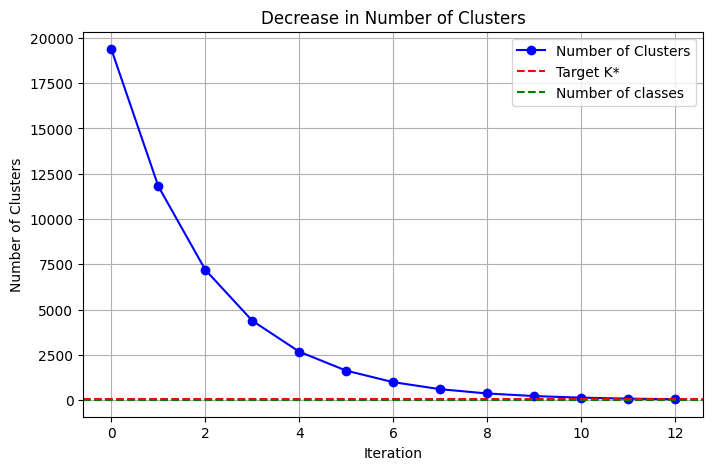

In [ ]:
k_star = num_classes * k_star_multiplier

# from src.util.over_clustering import linear_over_clustering

# k_values = linear_over_clustering(
#     max_cluster_size=18248, k_star=k_star, max_iter=num_epochs
# )

k_values = exponential_decay_over_clustering(
    k_star=k_star, lambda_v=lambda_v, max_iter=clusters_count
)

plot_k_values(k_values=k_values, k_star=k_star, num_classes=num_classes)

In [20]:
model = AdamOptimizedModule(
    FullyConvolutionalLeNet(target_dim, num_classes),
    lr=learning_rate,
    weight_decay=weight_decay,
    scheduler_step_size=scheduler_step_size,
    scheduler_gamma=scheduler_gamma,
)

loss = nn.CrossEntropyLoss()

base_trainer = ClassificationTrainer(
    num_epochs=1,
    num_classes=num_classes,
    criterion=loss,
    device=device,
    gradient_accumulation_steps=2,
)

clustering = KMeansClustering(seed=random_seed)

trainer = LabelPropagationTrainer(
    trainer=base_trainer,
    k_values=k_values,
    clustering=clustering,
    num_classes=num_classes,
    generator=generator,
    batch_size=batch_size,
    semantic_threshold=semantic_threshold,
    spatial_constraint_weights=spatial_constraint_weights,
    spatial_threshold=spatial_threshold,
)

In [ ]:
feedback = trainer.fit(
    model, x.transpose(0, 3, 1, 2), y_masked.reshape(image_h, image_w), test_loader
)

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[TrainerFeedback(history=[TrainerHistoryEntry(train={'train_loss': 2.4399807789307038}, eval={'eval_f1': 0.2877478003501892, 'eval_accuracy_overall': 0.7573331594467163, 'eval_accuracy_avg': 0.374377578496933, 'eval_kappa': 0.3460676074028015, 'eval_loss': 2.613368034362793})]),
 TrainerFeedback(history=[TrainerHistoryEntry(train={'train_loss': 2.293706067029168}, eval={'eval_f1': 0.24942627549171448, 'eval_accuracy_overall': 0.6409822702407837, 'eval_accuracy_avg': 0.32791876792907715, 'eval_kappa': 0.29527580738067627, 'eval_loss': 2.633697509765625})]),
 TrainerFeedback(history=[TrainerHistoryEntry(train={'train_loss': 2.185441117676152}, eval={'eval_f1': 0.2236771136522293, 'eval_accuracy_overall': 0.5654129981994629, 'eval_accuracy_avg': 0.2993473410606384, 'eval_kappa': 0.2646409869194031, 'eval_loss': 2.6476962566375732})]),
 TrainerFeedback(history=[TrainerHistoryEntry(train={'train_loss': 2.136375796599466}, eval={'eval_f1': 0.21505072712898254, 'eval_accuracy_overall': 0.4956

In [ ]:
train_loss =  [it.history[-1].train["train_loss"] for it in feedback]
eval_loss = [it.history[-1].train["eval_loss"] for it in feedback]

plot_epoch_generic_comparison(train_loss, eval_loss)

# plot_epoch_generic(smothed_train)

AttributeError: 'AdamOptimizedModule' object has no attribute 'train_metrics'

In [ ]:
eval_f1 = [it.history[-1].train["eval_f1"] for it in feedback]

plot_epoch_generic(eval_f1)

In [23]:
validation_result = base_trainer.validate(model, full_loader)

validation_result

{'eval_f1': 0.18268349766731262,
 'eval_accuracy_overall': 0.29021745920181274,
 'eval_accuracy_avg': 0.250368595123291,
 'eval_kappa': 0.2066943645477295,
 'eval_loss': 2.6780002117156982}

5. Display prediction

In [26]:
x.shape

(21025, 9, 9, 75)

In [28]:
y_pred = model(x_tensor.to(device))

In [29]:
y_pred = torch.argmax(y_pred, dim=1)
y_pred = y_pred.reshape(image_h, image_w)

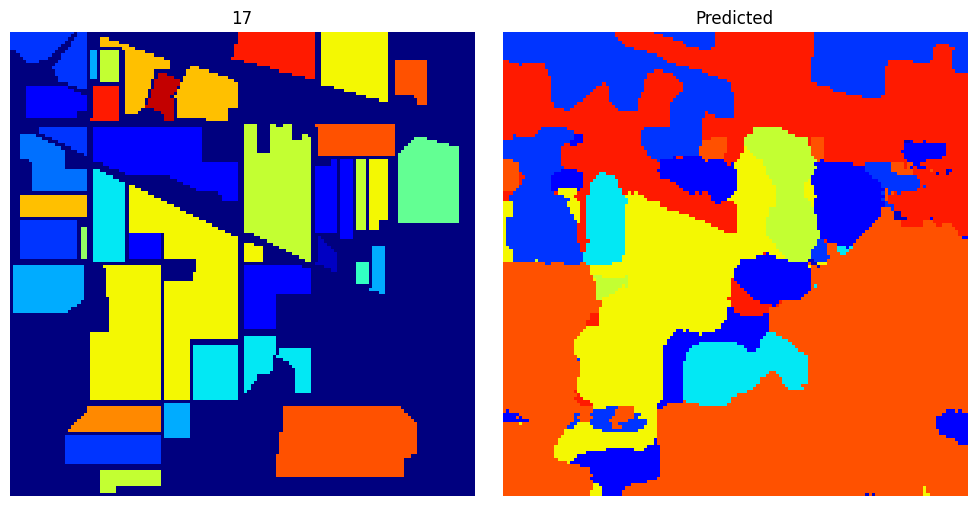

In [31]:
plot_segmentation_comparison(y.reshape(image_h, image_w), y_pred.cpu().numpy(), num_classes)

6. Write report

In [32]:
model_name = create_model_name("indian_pines_", examples_per_class)
model_category = "lenet_clustering"

report_run(
    model_name=model_name,
    model_category=model_category,
    run_desc="Default run",
    run_params={
        "learning_rate": learning_rate,
        "num_epochs": num_epochs,
        "batch_size": batch_size,
        "patch_size": patch_size,
        "target_dim": target_dim,
        "lambda_v": lambda_v,
        "clusters_count": clusters_count,
        "k_star_multiplier": k_star_multiplier,
        "semantic_threshold": semantic_threshold,
        "spatial_constraint_weights": spatial_constraint_weights,
        "spatial_threshold": spatial_threshold,
        "scheduler_step_size": scheduler_step_size,
        "scheduler_gamma": scheduler_gamma,
        "pre_process_type": str(pre_process_type),
        "dim_reduction_type": str(dim_reduction_type),
    },
    run_metrics=classification_trainer(validation_result),
)

PosixPath('/home/melal/Workspace/spatial-regulated-self-training/reports/runs/indian_pines__2020202020202020202020202020202020.csv')

In [33]:
read_report_to_show(model_name, sort_by_metric="f1")

,timestamp,model_category,run_desc,params,loss,f1,OA,AA,kappa
21,2025-05-25T13:49:18.465537+00:00,specteal_former,"With scheduling, incresed dropout and weight d...","{""hidden_dim"": 64, ""num_layers"": 5, ""num_heads...",1.709462,0.629933,3.285941e-01,0.592009,0.428213
19,2025-05-25T13:11:09.295934+00:00,specteal_former,"With scheduling, incresed dropout","{""hidden_dim"": 64, ""num_layers"": 5, ""num_heads...",1.884388,0.610363,3.212764e-01,0.573888,0.418024
17,2025-05-25T12:28:13.957191+00:00,specteal_former,With scheduling,"{""hidden_dim"": 64, ""num_layers"": 5, ""num_heads...",2.039043,0.588829,3.162847e-01,0.557241,0.407733
18,2025-05-25T12:48:49.301608+00:00,specteal_former,"With scheduling, incresed dropout","{""hidden_dim"": 64, ""num_layers"": 5, ""num_heads...",2.218621,0.575685,3.045633e-01,0.548062,0.399809
16,2025-05-25T11:54:50.924387+00:00,specteal_former,Default run,"{""hidden_dim"": 64, ""num_layers"": 5, ""num_heads...",2.187469,0.560617,2.933610e-01,0.531653,0.385957
20,2025-05-25T13:31:55.937456+00:00,specteal_former,"With scheduling, incresed dropout and weight d...","{""hidden_dim"": 64, ""num_layers"": 5, ""num_heads...",1.904269,0.550501,2.584340e-01,0.511486,0.363580
8,2025-05-25T00:13:59.916485+00:00,lenet,"A lot more epochs, PCA and scheduler","{""learning_rate"": 0.001, ""num_epochs"": 1000, ""...",2.457449,0.489860,2.897493e-01,0.478478,NaN
1,2025-05-24T19:21:48.509234+00:00,lenet,Default run (more epochs),"{""learning_rate"": 0.001, ""num_epochs"": 100, ""b...",2.559524,0.489064,2.364114e-01,0.443092,NaN
15,2025-05-25T11:31:53.271370+00:00,lenet,"More epochs, PCA, norm, and scheduler","{""learning_rate"": 0.001, ""num_epochs"": 1000, ""...",2.469688,0.473372,2.799799e-01,0.462592,NaN
7,2025-05-25T00:11:16.070258+00:00,lenet,"More epochs, PCA and scheduler","{""learning_rate"": 0.001, ""num_epochs"": 300, ""b...",2.513368,0.472783,2.816274e-01,0.463876,NaN


In [34]:
read_report_to_show(model_name, sort_by_metric="f1", model_category=model_category)

,timestamp,run_desc,params,loss,f1,OA,AA,kappa
25,2025-05-25T19:19:51.903381+00:00,Default run,"{""learning_rate"": 0.001, ""num_epochs"": 30, ""ba...",2.678,0.182683,0.290217,0.250369,0.206694
